# What Happens When You Predict on an Unseen Categorical Level
i.e. a rare event appears in your test set, which wasn't present in your training set.
___

> *This notebook walks through the steps of importing, cleaning, training, and testing on a data set where the test set contains a categorical level that was not present in the training set. You need to run steps 2. - 6. (to load all the variables) before you can jump between sections and run individual cells*

> Up to date for release H2O cluster version: 3.8.2.1

## Table of Contents
0. [Jump to The Short Answer](#question)
1. [Import, Visualize & Clean Data](#start)
2. [Split into Train and Test Sets](#split) 
3. [Build Models for GLM, GBM, DRF, Deep Learning & Naive Bayes](#build)
4. [Model Performance for GLM, GBM, DRF, Deep Learning & Naive Bayes](#output)
5. [How Each Algorithm Handles New Categorical Levels During Prediction](#answer)
6. [Bonus Section! How Each Algorithm Handles Missing Values During Training & Testing?](#missing)
6. [Additional Resources](#resources)

<a name="start"></a>
## Import Packages, Initialize an H2O Cluster & Load Data

In [ ]:
import h2o, pandas, pprint, operator, numpy as np, matplotlib.pyplot as plt
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.estimators.deeplearning import H2ODeepLearningEstimator
from h2o.estimators.naive_bayes import H2ONaiveBayesEstimator
from tabulate import tabulate

In [2]:
# Set 'interactive = True' for interactive plots, 'interactive = False' if not:
interactive = True
if not interactive: matplotlib.use('Agg', warn=False)

In [29]:
h2o.shutdown()

Are you sure you want to shutdown the H2O instance running at localhost:54321 (Y/N)? Y


In [30]:
# Connect to a cluster 
h2o.init()



No instance found at ip and port: localhost:54321. Trying to start local jar...


JVM stdout: /var/folders/k_/kpp1czqs3957vq2pr5qngck00000gn/T/tmp2t03b5ln/h2o_laurend_started_from_python.out
JVM stderr: /var/folders/k_/kpp1czqs3957vq2pr5qngck00000gn/T/tmpvtztzyoa/h2o_laurend_started_from_python.err
Using ice_root: /var/folders/k_/kpp1czqs3957vq2pr5qngck00000gn/T/tmpxlwqpn0y


Java Version: java version "1.8.0_73"
Java(TM) SE Runtime Environment (build 1.8.0_73-b02)
Java HotSpot(TM) 64-Bit Server VM (build 25.73-b02, mixed mode)


Starting H2O JVM and connecting: .............. Connection successful!


H2O cluster uptime:,1 seconds 518 milliseconds
H2O cluster version:,3.9.1.3460
H2O cluster name:,H2O_started_from_python_laurend_itz611
H2O cluster total nodes:,1
H2O cluster total free memory:,3.56 GB
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster healthy:,True
H2O Connection ip:,127.0.0.1
H2O Connection port:,54321
H2O Connection proxy:,None


In [31]:
# 1 - Load data - One row per flight.  
# Columns include origin, destination, departure & arrival times, carrier information, and whether flight was delayed.
print("Import and Parse airlines data")
# air_path = 'allyears2k_headers.zip'
air_path = "http://h2o-public-test-data.s3.amazonaws.com/smalldata/airlines/allyears2k_headers.zip"
data = h2o.import_file(path = air_path)
# data.describe() # uncomment to see summary of loaded data file
# data.head()     # uncomment to see top of the loaded data file

Import and Parse airlines data

Parse Progress: [##################################################] 100%


## Explore Data with Visualizations


glm Model Build Progress: [##################################################] 100%


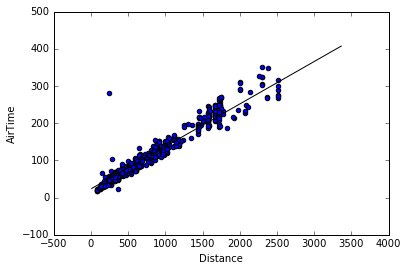

In [32]:
# 2 - Data exploration and munging. 
# Generate scatter plots of various columns and plot fitted GLM model.

# Function to fit a GLM model and plot the fitted (x,y) values
def scatter_plot(data, x, y, max_points = 1000, fit = True):
    if(fit):
        lr = H2OGeneralizedLinearEstimator(family = "gaussian")
        lr.train(x=x, y=y, training_frame=data)
        coeff = lr.coef()
    df = data[[x,y]]
    runif = df[y].runif()
    df_subset = df[runif < float(max_points)/data.nrow]
    df_py = h2o.as_list(df_subset)
    
    if(fit): h2o.remove(lr._id)

    # If x variable is string, generate box-and-whisker plot
    if(df_py[x].dtype == "object"):
        if interactive: df_py.boxplot(column = y, by = x)
    # Otherwise, generate a scatter plot
    else:
        if interactive: df_py.plot(x = x, y = y, kind = "scatter")
    
    if(fit):
        x_min = min(df_py[x])
        x_max = max(df_py[x])
        y_min = coeff["Intercept"] + coeff[x]*x_min
        y_max = coeff["Intercept"] + coeff[x]*x_max
        plt.plot([x_min, x_max], [y_min, y_max], "k-")
    if interactive: plt.show()
        
# generate matplotlib plots inside of ipython notebook        
%matplotlib inline  
scatter_plot(data, "Distance", "AirTime", fit = True)

In [6]:
# Group flights by month
grouped = data.group_by("Month")
bpd = grouped.count().sum("Cancelled").frame
bpd.show()
bpd.describe()
bpd.dim

# Convert columns to factors
data["Year"]= data["Year"].asfactor()
data["Month"] = data["Month"].asfactor()
data["DayOfWeek"] = data["DayOfWeek"].asfactor()
data["Cancelled"] = data["Cancelled"].asfactor()

Month,sum_Cancelled,nrow_Year
1,1067,41979
10,19,1999


Rows:2 Cols:3

Chunk compression summary: 


chunk_type,chunk_name,count,count_percentage,size,size_percentage
C1N,1-Byte Integers (w/o NAs),1,33.333336,70 B,30.434782
C2,2-Byte Integers,1,33.333336,72 B,31.304348
C2S,2-Byte Fractions,1,33.333336,88 B,38.260868



Frame distribution summary: 


,size,number_of_rows,number_of_chunks_per_column,number_of_chunks
127.0.0.1:54321,230 B,2.0,1.0,3.0
mean,230 B,2.0,1.0,3.0
min,230 B,2.0,1.0,3.0
max,230 B,2.0,1.0,3.0
stddev,0 B,0.0,0.0,0.0
total,230 B,2.0,1.0,3.0


,Month,sum_Cancelled,nrow_Year
type,int,int,int
mins,1.0,19.0,1999.0
mean,5.5,543.0,21989.0
maxs,10.0,1067.0,41979.0
sigma,6.363961030678928,741.0479066835018,28270.12911183817
zeros,0,0,0
missing,0,0,0
0,1.0,1067.0,41979.0
1,10.0,19.0,1999.0



Parse Progress: [##################################################] 100%

glm Model Build Progress: [##################################################] 100%


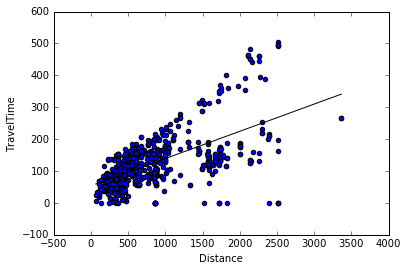

In [7]:
# Calculate and plot travel time
hour1 = data["CRSArrTime"] / 100
mins1 = data["CRSArrTime"] % 100
arrTime = hour1*60 + mins1

hour2 = data["CRSDepTime"] / 100
mins2 = data["CRSDepTime"] % 100
depTime = hour2*60 + mins2

data["TravelTime"] = (arrTime-depTime > 0).ifelse((arrTime-depTime), h2o.H2OFrame([[None]] * data.nrow))

scatter_plot(data, "Distance", "TravelTime")


glm Model Build Progress: [##################################################] 100%


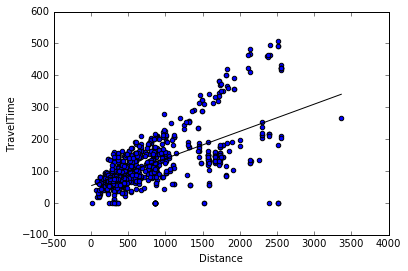

In [8]:
# Impute missing travel times and re-plot
data.impute(column = "Distance", by = ["Origin", "Dest"])
scatter_plot(data, "Distance", "TravelTime")

<a name="split"></a>
# Split Data Set into Train and Test Sets 

In [9]:
# 3 - Fit a model on train; using test as validation.
# Create test/train split
s = data["Year"].runif()
train = data[s <= 0.75]
test  = data[s > 0.75]

In [10]:
# Replace all instances of 'SFO' in the destination column ('Dest') with 'BB8'
test["Dest"] = (test["Dest"] == 'SFO').ifelse('BB8', test["Dest"])
# print out the number of rows that were effected
test[test['Dest']=='BB8'].shape

(304, 32)

>*We replace all instances of 'SFO' from the 'Dest' column, to create the situation in which your test set has a categorical level that was not present in the training set (Note: all models will run without breaking, because new categorical levels are interpreted as if they were NA values)*

<a name="build"></a>
# Build Models with Supervised Learning Algorithms 

Train models for GLM, GBM, DRF, Deep Learning & Naive Bayes in one go! 

In [11]:
# Set response column
myY = "IsDepDelayed"
# Set feature columns
myX = ["Origin", "Dest", "Year", "UniqueCarrier", "DayOfWeek", "Month", "Distance", "FlightNum"]

# Predict delays with GLM
data_glm = H2OGeneralizedLinearEstimator(family="binomial", standardize=True)
data_glm.train(x = myX, y = myY, training_frame = train, validation_frame = test)

# Predict delays with GBM
data_gbm2 = H2OGradientBoostingEstimator(balance_classes = False, ntrees = 50, max_depth = 5,
                                         distribution = "bernoulli", learn_rate = 0.1, min_rows = 2)
data_gbm2.train(x = myX, y = myY, training_frame = train, validation_frame = test)

# Predict delays with Distributed Random Forest (DRF)
data_rf2 = H2ORandomForestEstimator(ntrees = 10,max_depth = 5, balance_classes = False)
data_rf2.train(x = myX, y = myY, training_frame = train, validation_frame = test)

# Predict delays with Deep Learning
data_dl = H2ODeepLearningEstimator(hidden = [10,10], epochs = 5, variable_importances = True,
                                   balance_classes = False, loss = "Automatic")
data_dl.train(x = myX, y = myY, training_frame = train, validation_frame=test)

# Predict delays with Naive Bayes
# If laplace smoothing is disabled ('laplace=0') the algorithm will predict 0
data_nb = H2ONaiveBayesEstimator(laplace=1) 
data_nb.train(x = myX, y = myY, training_frame = train, validation_frame=test)


glm Model Build Progress: [##################################################] 100%

gbm Model Build Progress: [##################################################] 100%

drf Model Build Progress: [##################################################] 100%

deeplearning Model Build Progress: [##################################################] 100%

naivebayes Model Build Progress: [##################################################] 100%


### Or build models individually 

<a name="GLM Model"></a>
`Build GLM` 

In [12]:
# Set response column
myY = "IsDepDelayed"
# Set feature columns
myX = ["Origin", "Dest", "Year", "UniqueCarrier", "DayOfWeek", "Month", "Distance", "FlightNum"]

# Predict delays with GLM
data_glm = H2OGeneralizedLinearEstimator(family="binomial", standardize=True)
data_glm.train(x = myX, y = myY, training_frame = train, validation_frame = test)

data_glm.model_performance(test)


glm Model Build Progress: [##################################################] 100%

ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.21416530940414985
R^2: 0.14200193566672592
LogLoss: 0.616556553874648
Null degrees of freedom: 10918
Residual degrees of freedom: 10678
Null deviance: 15122.125326794045
Residual deviance: 13464.362023514564
AIC: 13946.362023514564
AUC: 0.7166694556732763
Gini: 0.43333891134655267

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.331854947054549: 


,NO,YES,Error,Rate
NO,1496.0,3748.0,0.7147,(3748.0/5244.0)
YES,505.0,5170.0,0.089,(505.0/5675.0)
Total,2001.0,8918.0,0.3895,(4253.0/10919.0)



Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.3318549,0.7085589,314.0
max f2,0.1648148,0.8451715,379.0
max f0point5,0.5324188,0.6755473,203.0
max accuracy,0.5097744,0.6633391,216.0
max precision,0.9797664,1.0,0.0
max recall,0.0806012,1.0,399.0
max specificity,0.9797664,1.0,0.0
max absolute_MCC,0.5097744,0.3251416,216.0
max min_per_class_accuracy,0.5269278,0.6601831,207.0



Gains/Lift Table: Avg response rate: 51.97 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100742,0.9115665,1.8540873,1.8540873,0.9636364,0.9636364,0.0186784,0.0186784,85.4087305,85.4087305
,2,0.0200568,0.8818044,1.6239712,1.7395546,0.8440367,0.9041096,0.0162115,0.0348899,62.3971224,73.9554644
,3,0.0300394,0.8647063,1.7828380,1.7539384,0.9266055,0.9115854,0.0177974,0.0526872,78.2837974,75.3938433
,4,0.0400220,0.8536446,1.6769268,1.7347296,0.8715596,0.9016018,0.0167401,0.0694273,67.6926808,73.4729584
,5,0.0500046,0.8431967,1.5180601,1.6914750,0.7889908,0.8791209,0.0151542,0.0845815,51.8060057,69.1475045
,6,0.1000092,0.7799468,1.5364232,1.6139491,0.7985348,0.8388278,0.0768282,0.1614097,53.6423166,61.3949105
,7,0.1500137,0.7336259,1.4694689,1.5657891,0.7637363,0.8137973,0.0734802,0.2348899,46.9468945,56.5789052
,8,0.2001099,0.6998976,1.3120141,1.5022582,0.6819013,0.7807780,0.0657269,0.3006167,31.2014110,50.2258208
,9,0.3000275,0.6405624,1.2662419,1.4236582,0.6581118,0.7399267,0.1265198,0.4271366,26.6241939,42.3658163
,10,0.4000366,0.5861789,1.2245575,1.3738830,0.6364469,0.7140568,0.1224670,0.5496035,22.4557454,37.3882986


In [13]:
glm_pred_output = data_glm.predict(test)
glm_pred_output.head()


glm prediction Progress: [##################################################] 100%


predict,NO,YES
YES,0.462817,0.537183
YES,0.426812,0.573188
YES,0.293095,0.706905
YES,0.351103,0.648897
YES,0.386998,0.613002
YES,0.356089,0.643911
YES,0.318634,0.681366
YES,0.471821,0.528179
YES,0.49142,0.50858
YES,0.529944,0.470056


<a name="GBM Model"></a>
`Build GBM`

In [14]:
# Set response column
myY = "IsDepDelayed"
# Set feature columns
myX = ["Origin", "Dest", "Year", "UniqueCarrier", "DayOfWeek", "Month", "Distance", "FlightNum"]

# Predict delays with GBM
data_gbm2 = H2OGradientBoostingEstimator(balance_classes = False, ntrees = 50, max_depth = 5,
                                         distribution = "bernoulli", learn_rate = 0.1, min_rows = 2)
data_gbm2.train(x = myX, y = myY, training_frame = train, validation_frame = test)

data_gbm2.model_performance(test)


gbm Model Build Progress: [##################################################] 100%

ModelMetricsBinomial: gbm
** Reported on test data. **

MSE: 0.20994431051192827
R^2: 0.1589122788458105
LogLoss: 0.6074948423093912
AUC: 0.7296870936198954
Gini: 0.45937418723979073

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.37325809173716235: 


,NO,YES,Error,Rate
NO,2249.0,2995.0,0.5711,(2995.0/5244.0)
YES,839.0,4836.0,0.1478,(839.0/5675.0)
Total,3088.0,7831.0,0.3511,(3834.0/10919.0)



Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.3732581,0.7161262,285.0
max f2,0.1949921,0.8460707,369.0
max f0point5,0.5645440,0.6866944,177.0
max accuracy,0.4746806,0.6727722,226.0
max precision,0.9572355,1.0,0.0
max recall,0.0846539,1.0,398.0
max specificity,0.9572355,1.0,0.0
max absolute_MCC,0.4746806,0.3435593,226.0
max min_per_class_accuracy,0.5078917,0.6697178,209.0



Gains/Lift Table: Avg response rate: 51.97 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100742,0.8994217,1.8191045,1.8191045,0.9454545,0.9454545,0.0183260,0.0183260,81.9104525,81.9104525
,2,0.0200568,0.8855835,1.6769268,1.7483403,0.8715596,0.9086758,0.0167401,0.0350661,67.6926808,74.8340273
,3,0.0300394,0.8727916,1.7475343,1.7480724,0.9082569,0.9085366,0.0174449,0.0525110,74.7534252,74.8072419
,4,0.0401136,0.8609245,1.7316476,1.7439475,0.9,0.9063927,0.0174449,0.0699559,73.1647577,74.3947458
,5,0.0500046,0.8495728,1.6568233,1.7267141,0.8611111,0.8974359,0.0163877,0.0863436,65.6823299,72.6714108
,6,0.1000092,0.7923066,1.5082319,1.6174730,0.7838828,0.8406593,0.0754185,0.1617621,50.8231915,61.7473012
,7,0.1504717,0.7499476,1.4456586,1.5598530,0.7513612,0.8107121,0.0729515,0.2347137,44.5658594,55.9852960
,8,0.2001099,0.7143123,1.4057656,1.5216308,0.7306273,0.7908467,0.0697797,0.3044934,40.5765561,52.1630823
,9,0.3001191,0.6513619,1.3478942,1.4637363,0.7005495,0.7607568,0.1348018,0.4392952,34.7894176,46.3736280
,10,0.4001282,0.5829166,1.2016521,1.3982302,0.6245421,0.7267109,0.1201762,0.5594714,20.1652063,39.8230222


In [15]:
data_gbm2.predict(test)


gbm prediction Progress: [##################################################] 100%


predict,NO,YES
NO,0.709207,0.290793
NO,0.696442,0.303558
YES,0.275673,0.724327
YES,0.31818,0.68182
YES,0.316426,0.683574
YES,0.310093,0.689907
YES,0.281212,0.718788
YES,0.415032,0.584968
YES,0.455974,0.544026
YES,0.491473,0.508527


<a name="DRF Model"></a>
`Build Distributed Random Forest`

In [16]:
# Set response column
myY = "IsDepDelayed"
# Set feature columns
myX = ["Origin", "Dest", "Year", "UniqueCarrier", "DayOfWeek", "Month", "Distance", "FlightNum"]

# Predict delays with Distributed Random Forest (DRF)
data_rf2 = H2ORandomForestEstimator(ntrees = 10,max_depth = 5, balance_classes = False)
data_rf2.train(x = myX, y = myY, training_frame = train, validation_frame = test)

data_rf2.model_performance(test)


drf Model Build Progress: [##################################################] 100%

ModelMetricsBinomial: drf
** Reported on test data. **

MSE: 0.21599360206518958
R^2: 0.1346773527612536
LogLoss: 0.6214047527338338
AUC: 0.7177846214847596
Gini: 0.43556924296951927

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4300728998567959: 


,NO,YES,Error,Rate
NO,2368.0,2876.0,0.5484,(2876.0/5244.0)
YES,985.0,4690.0,0.1736,(985.0/5675.0)
Total,3353.0,7566.0,0.3536,(3861.0/10919.0)



Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.4300729,0.7084057,301.0
max f2,0.3002093,0.8444856,386.0
max f0point5,0.5293900,0.6774533,232.0
max accuracy,0.4886548,0.6656287,264.0
max precision,0.8944711,1.0,0.0
max recall,0.2455635,1.0,398.0
max specificity,0.8944711,1.0,0.0
max absolute_MCC,0.4886548,0.3292966,264.0
max min_per_class_accuracy,0.5210644,0.6616740,238.0



Gains/Lift Table: Avg response rate: 51.97 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100742,0.8454385,1.8016131,1.8016131,0.9363636,0.9363636,0.0181498,0.0181498,80.1613136,80.1613136
,2,0.0202399,0.8320967,1.8373838,1.8195794,0.9549550,0.9457014,0.0186784,0.0368282,83.7383816,81.9579405
,3,0.0303141,0.8236593,1.6092078,1.7496674,0.8363636,0.9093656,0.0162115,0.0530396,60.9207849,74.9667408
,4,0.0401136,0.8111829,1.7082712,1.7395546,0.8878505,0.9041096,0.0167401,0.0697797,70.8271234,73.9554644
,5,0.0500046,0.8015050,1.6033774,1.7126185,0.8333333,0.8901099,0.0158590,0.0856388,60.3377386,71.2618483
,6,0.1001007,0.7491098,1.5300969,1.6212742,0.7952468,0.8426349,0.0766520,0.1622907,53.0096884,62.1274188
,7,0.1501053,0.7138253,1.4659450,1.5695294,0.7619048,0.8157413,0.0733040,0.2355947,46.5945039,56.9529395
,8,0.2001099,0.6809330,1.3884191,1.5242725,0.7216117,0.7922197,0.0694273,0.3050220,38.8419099,52.4272543
,9,0.3000275,0.6356334,1.2609512,1.4365792,0.6553621,0.7466422,0.1259912,0.4310132,26.0951235,43.6579153
,10,0.4000366,0.5751088,1.1681750,1.3694781,0.6071429,0.7117674,0.1168282,0.5478414,16.8174953,36.9478103


In [17]:
data_rf2.predict(test)


drf prediction Progress: [##################################################] 100%


predict,NO,YES
YES,0.353397,0.646603
YES,0.370599,0.629401
YES,0.263289,0.736711
YES,0.269306,0.730694
YES,0.269306,0.730694
YES,0.285171,0.714829
YES,0.259891,0.740109
YES,0.500777,0.499223
YES,0.514697,0.485303
YES,0.514697,0.485303


<a name="DL Model"></a>
`Build Deep Learning`

In [18]:
# Set response column
myY = "IsDepDelayed"
# Set feature columns
myX = ["Origin", "Dest", "Year", "UniqueCarrier", "DayOfWeek", "Month", "Distance", "FlightNum"]

# Predict delays with Deep Learning
data_dl = H2ODeepLearningEstimator(hidden = [10,10], epochs = 5, variable_importances = True,
                                   balance_classes = False, loss = "Automatic")
data_dl.train(x = myX, y = myY, training_frame = train, validation_frame=test)

data_dl.model_performance(test)


deeplearning Model Build Progress: [##################################################] 100%

ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.22280968518794017
R^2: 0.10737047406121802
LogLoss: 0.6374853419025917
AUC: 0.708553916874162
Gini: 0.41710783374832405

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.25611323581363243: 


,NO,YES,Error,Rate
NO,1714.0,3530.0,0.6732,(3530.0/5244.0)
YES,627.0,5048.0,0.1105,(627.0/5675.0)
Total,2341.0,8578.0,0.3807,(4157.0/10919.0)



Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.2561132,0.7083421,315.0
max f2,0.0759424,0.8445140,391.0
max f0point5,0.4576310,0.6688179,214.0
max accuracy,0.4132508,0.6553714,237.0
max precision,0.9607276,1.0,0.0
max recall,0.0476740,1.0,398.0
max specificity,0.9607276,1.0,0.0
max absolute_MCC,0.4132508,0.3090235,237.0
max min_per_class_accuracy,0.4319226,0.6519824,227.0



Gains/Lift Table: Avg response rate: 51.97 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0101658,0.9026969,1.8373838,1.8373838,0.9549550,0.9549550,0.0186784,0.0186784,83.7383816,83.7383816
,2,0.0201484,0.8678130,1.6769268,1.7578847,0.8715596,0.9136364,0.0167401,0.0354185,67.6926808,75.7884662
,3,0.0300394,0.8432173,1.6390080,1.7187423,0.8518519,0.8932927,0.0162115,0.0516300,63.9007995,71.8742344
,4,0.0400220,0.8207134,1.6945787,1.7127152,0.8807339,0.8901602,0.0169163,0.0685463,69.4578669,71.2715249
,5,0.0500046,0.8009048,1.3944970,1.6491882,0.7247706,0.8571429,0.0139207,0.0824670,39.4497029,64.9188169
,6,0.1000092,0.7365274,1.4800407,1.5646144,0.7692308,0.8131868,0.0740088,0.1564758,48.0040664,56.4614416
,7,0.1500137,0.6847974,1.4307060,1.5199783,0.7435897,0.7899878,0.0715419,0.2280176,43.0705975,51.9978269
,8,0.2001099,0.6468197,1.3225665,1.4705576,0.6873857,0.7643021,0.0662555,0.2942731,32.2566502,47.0557566
,9,0.3000275,0.5703766,1.3244397,1.4218962,0.6883593,0.7390110,0.1323348,0.4266079,32.4439689,42.1896210
,10,0.4002198,0.5007653,1.1414171,1.3516802,0.5932358,0.7025172,0.1143612,0.5409692,14.1417101,35.1680158


In [19]:
data_dl.predict(test)


deeplearning prediction Progress: [##################################################] 100%


predict,NO,YES
YES,0.623984,0.376016
YES,0.550361,0.449639
YES,0.402294,0.597706
YES,0.566555,0.433445
YES,0.528912,0.471088
YES,0.507642,0.492358
YES,0.442312,0.557688
YES,0.47574,0.52426
YES,0.518665,0.481335
YES,0.489721,0.510279


<a name="NB Model"></a>
`Build Naive Bayes`

In [20]:
# Set response column
myY = "IsDepDelayed"
# Set feature columns
myX = ["Origin", "Dest", "Year", "UniqueCarrier", "DayOfWeek", "Month", "Distance", "FlightNum"]

# Predict delays with Naive Bayes
# If laplace smoothing is disabled ('laplace=0') the algorithm will predict 0
data_nb = H2ONaiveBayesEstimator(laplace=1) 
data_nb.train(x = myX, y = myY, training_frame = train, validation_frame=test)

data_nb.model_performance(test)


naivebayes Model Build Progress: [##################################################] 100%

ModelMetricsBinomial: naivebayes
** Reported on test data. **

MSE: 0.23152996070216778
R^2: 0.07243493976541415
LogLoss: 0.6647084512439999
AUC: 0.6877895778519272
Gini: 0.37557915570385436

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.22770709644158957: 


,NO,YES,Error,Rate
NO,1199.0,4045.0,0.7714,(4045.0/5244.0)
YES,425.0,5250.0,0.0749,(425.0/5675.0)
Total,1624.0,9295.0,0.4094,(4470.0/10919.0)



Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.2277071,0.7014028,334.0
max f2,0.0639758,0.8453940,390.0
max f0point5,0.5630666,0.6520698,188.0
max accuracy,0.4959973,0.6370547,218.0
max precision,0.9974487,1.0,0.0
max recall,0.0207270,1.0,398.0
max specificity,0.9974487,1.0,0.0
max absolute_MCC,0.5630666,0.2765067,188.0
max min_per_class_accuracy,0.4985902,0.6366520,217.0



Gains/Lift Table: Avg response rate: 51.97 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100742,0.9849015,1.8365959,1.8365959,0.9545455,0.9545455,0.0185022,0.0185022,83.6595915,83.6595915
,2,0.0200568,0.9736685,1.6945787,1.7659115,0.8807339,0.9178082,0.0169163,0.0354185,69.4578669,76.5911532
,3,0.0300394,0.9599325,1.5533638,1.6952783,0.8073394,0.8810976,0.0155066,0.0509251,55.3363780,69.5278285
,4,0.0400220,0.9461100,1.4651045,1.6378665,0.7614679,0.8512586,0.0146256,0.0655507,46.5104474,63.7866511
,5,0.0500046,0.9340485,1.5533638,1.6209969,0.8073394,0.8424908,0.0155066,0.0810573,55.3363780,62.0996918
,6,0.1000092,0.8714906,1.5328993,1.5769481,0.7967033,0.8195971,0.0766520,0.1577093,53.2899259,57.6948089
,7,0.1501053,0.8159428,1.3682935,1.5073117,0.7111517,0.7834045,0.0685463,0.2262555,36.8293535,50.7311700
,8,0.2001099,0.7705500,1.3743235,1.4740799,0.7142857,0.7661327,0.0687225,0.2949780,37.4323474,47.4079860
,9,0.3001191,0.6889571,1.2227955,1.3903440,0.6355311,0.7226121,0.1222907,0.4172687,22.2795501,39.0343967
,10,0.4001282,0.6054809,1.0941729,1.3163182,0.5686813,0.6841382,0.1094273,0.5266960,9.4172920,31.6318153


In [21]:
data_nb.predict(test)


naivebayes prediction Progress: [##################################################] 100%


predict,NO,YES
YES,0.396596,0.603404
YES,0.307507,0.692493
YES,0.260807,0.739193
YES,0.296727,0.703273
YES,0.285976,0.714024
YES,0.333018,0.666982
YES,0.221825,0.778175
YES,0.498704,0.501296
YES,0.509004,0.490996
YES,0.495986,0.504014


<a name="output"></a>
## Model Performance and Output 

Run each cell below to see each model's performance on the test set

In [22]:
# GLM performance
data_glm.model_performance(test)


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.21416530940414985
R^2: 0.14200193566672592
LogLoss: 0.616556553874648
Null degrees of freedom: 10918
Residual degrees of freedom: 10678
Null deviance: 15122.125326794045
Residual deviance: 13464.362023514564
AIC: 13946.362023514564
AUC: 0.7166694556732763
Gini: 0.43333891134655267

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.331854947054549: 


,NO,YES,Error,Rate
NO,1496.0,3748.0,0.7147,(3748.0/5244.0)
YES,505.0,5170.0,0.089,(505.0/5675.0)
Total,2001.0,8918.0,0.3895,(4253.0/10919.0)



Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.3318549,0.7085589,314.0
max f2,0.1648148,0.8451715,379.0
max f0point5,0.5324188,0.6755473,203.0
max accuracy,0.5097744,0.6633391,216.0
max precision,0.9797664,1.0,0.0
max recall,0.0806012,1.0,399.0
max specificity,0.9797664,1.0,0.0
max absolute_MCC,0.5097744,0.3251416,216.0
max min_per_class_accuracy,0.5269278,0.6601831,207.0



Gains/Lift Table: Avg response rate: 51.97 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100742,0.9115665,1.8540873,1.8540873,0.9636364,0.9636364,0.0186784,0.0186784,85.4087305,85.4087305
,2,0.0200568,0.8818044,1.6239712,1.7395546,0.8440367,0.9041096,0.0162115,0.0348899,62.3971224,73.9554644
,3,0.0300394,0.8647063,1.7828380,1.7539384,0.9266055,0.9115854,0.0177974,0.0526872,78.2837974,75.3938433
,4,0.0400220,0.8536446,1.6769268,1.7347296,0.8715596,0.9016018,0.0167401,0.0694273,67.6926808,73.4729584
,5,0.0500046,0.8431967,1.5180601,1.6914750,0.7889908,0.8791209,0.0151542,0.0845815,51.8060057,69.1475045
,6,0.1000092,0.7799468,1.5364232,1.6139491,0.7985348,0.8388278,0.0768282,0.1614097,53.6423166,61.3949105
,7,0.1500137,0.7336259,1.4694689,1.5657891,0.7637363,0.8137973,0.0734802,0.2348899,46.9468945,56.5789052
,8,0.2001099,0.6998976,1.3120141,1.5022582,0.6819013,0.7807780,0.0657269,0.3006167,31.2014110,50.2258208
,9,0.3000275,0.6405624,1.2662419,1.4236582,0.6581118,0.7399267,0.1265198,0.4271366,26.6241939,42.3658163
,10,0.4000366,0.5861789,1.2245575,1.3738830,0.6364469,0.7140568,0.1224670,0.5496035,22.4557454,37.3882986


In [23]:
# Distributed Random Forest Performance
data_rf2.model_performance(test)


ModelMetricsBinomial: drf
** Reported on test data. **

MSE: 0.21599360206518958
R^2: 0.1346773527612536
LogLoss: 0.6214047527338338
AUC: 0.7177846214847596
Gini: 0.43556924296951927

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4300728998567959: 


,NO,YES,Error,Rate
NO,2368.0,2876.0,0.5484,(2876.0/5244.0)
YES,985.0,4690.0,0.1736,(985.0/5675.0)
Total,3353.0,7566.0,0.3536,(3861.0/10919.0)



Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.4300729,0.7084057,301.0
max f2,0.3002093,0.8444856,386.0
max f0point5,0.5293900,0.6774533,232.0
max accuracy,0.4886548,0.6656287,264.0
max precision,0.8944711,1.0,0.0
max recall,0.2455635,1.0,398.0
max specificity,0.8944711,1.0,0.0
max absolute_MCC,0.4886548,0.3292966,264.0
max min_per_class_accuracy,0.5210644,0.6616740,238.0



Gains/Lift Table: Avg response rate: 51.97 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100742,0.8454385,1.8016131,1.8016131,0.9363636,0.9363636,0.0181498,0.0181498,80.1613136,80.1613136
,2,0.0202399,0.8320967,1.8373838,1.8195794,0.9549550,0.9457014,0.0186784,0.0368282,83.7383816,81.9579405
,3,0.0303141,0.8236593,1.6092078,1.7496674,0.8363636,0.9093656,0.0162115,0.0530396,60.9207849,74.9667408
,4,0.0401136,0.8111829,1.7082712,1.7395546,0.8878505,0.9041096,0.0167401,0.0697797,70.8271234,73.9554644
,5,0.0500046,0.8015050,1.6033774,1.7126185,0.8333333,0.8901099,0.0158590,0.0856388,60.3377386,71.2618483
,6,0.1001007,0.7491098,1.5300969,1.6212742,0.7952468,0.8426349,0.0766520,0.1622907,53.0096884,62.1274188
,7,0.1501053,0.7138253,1.4659450,1.5695294,0.7619048,0.8157413,0.0733040,0.2355947,46.5945039,56.9529395
,8,0.2001099,0.6809330,1.3884191,1.5242725,0.7216117,0.7922197,0.0694273,0.3050220,38.8419099,52.4272543
,9,0.3000275,0.6356334,1.2609512,1.4365792,0.6553621,0.7466422,0.1259912,0.4310132,26.0951235,43.6579153
,10,0.4000366,0.5751088,1.1681750,1.3694781,0.6071429,0.7117674,0.1168282,0.5478414,16.8174953,36.9478103


In [24]:
# GBM Performance
data_gbm2.model_performance(test)


ModelMetricsBinomial: gbm
** Reported on test data. **

MSE: 0.20994431051192827
R^2: 0.1589122788458105
LogLoss: 0.6074948423093912
AUC: 0.7296870936198954
Gini: 0.45937418723979073

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.37325809173716235: 


,NO,YES,Error,Rate
NO,2249.0,2995.0,0.5711,(2995.0/5244.0)
YES,839.0,4836.0,0.1478,(839.0/5675.0)
Total,3088.0,7831.0,0.3511,(3834.0/10919.0)



Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.3732581,0.7161262,285.0
max f2,0.1949921,0.8460707,369.0
max f0point5,0.5645440,0.6866944,177.0
max accuracy,0.4746806,0.6727722,226.0
max precision,0.9572355,1.0,0.0
max recall,0.0846539,1.0,398.0
max specificity,0.9572355,1.0,0.0
max absolute_MCC,0.4746806,0.3435593,226.0
max min_per_class_accuracy,0.5078917,0.6697178,209.0



Gains/Lift Table: Avg response rate: 51.97 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100742,0.8994217,1.8191045,1.8191045,0.9454545,0.9454545,0.0183260,0.0183260,81.9104525,81.9104525
,2,0.0200568,0.8855835,1.6769268,1.7483403,0.8715596,0.9086758,0.0167401,0.0350661,67.6926808,74.8340273
,3,0.0300394,0.8727916,1.7475343,1.7480724,0.9082569,0.9085366,0.0174449,0.0525110,74.7534252,74.8072419
,4,0.0401136,0.8609245,1.7316476,1.7439475,0.9,0.9063927,0.0174449,0.0699559,73.1647577,74.3947458
,5,0.0500046,0.8495728,1.6568233,1.7267141,0.8611111,0.8974359,0.0163877,0.0863436,65.6823299,72.6714108
,6,0.1000092,0.7923066,1.5082319,1.6174730,0.7838828,0.8406593,0.0754185,0.1617621,50.8231915,61.7473012
,7,0.1504717,0.7499476,1.4456586,1.5598530,0.7513612,0.8107121,0.0729515,0.2347137,44.5658594,55.9852960
,8,0.2001099,0.7143123,1.4057656,1.5216308,0.7306273,0.7908467,0.0697797,0.3044934,40.5765561,52.1630823
,9,0.3001191,0.6513619,1.3478942,1.4637363,0.7005495,0.7607568,0.1348018,0.4392952,34.7894176,46.3736280
,10,0.4001282,0.5829166,1.2016521,1.3982302,0.6245421,0.7267109,0.1201762,0.5594714,20.1652063,39.8230222


In [25]:
# Deep Learning Performance
data_dl.model_performance(test)


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.22280968518794017
R^2: 0.10737047406121802
LogLoss: 0.6374853419025917
AUC: 0.708553916874162
Gini: 0.41710783374832405

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.25611323581363243: 


,NO,YES,Error,Rate
NO,1714.0,3530.0,0.6732,(3530.0/5244.0)
YES,627.0,5048.0,0.1105,(627.0/5675.0)
Total,2341.0,8578.0,0.3807,(4157.0/10919.0)



Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.2561132,0.7083421,315.0
max f2,0.0759424,0.8445140,391.0
max f0point5,0.4576310,0.6688179,214.0
max accuracy,0.4132508,0.6553714,237.0
max precision,0.9607276,1.0,0.0
max recall,0.0476740,1.0,398.0
max specificity,0.9607276,1.0,0.0
max absolute_MCC,0.4132508,0.3090235,237.0
max min_per_class_accuracy,0.4319226,0.6519824,227.0



Gains/Lift Table: Avg response rate: 51.97 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0101658,0.9026969,1.8373838,1.8373838,0.9549550,0.9549550,0.0186784,0.0186784,83.7383816,83.7383816
,2,0.0201484,0.8678130,1.6769268,1.7578847,0.8715596,0.9136364,0.0167401,0.0354185,67.6926808,75.7884662
,3,0.0300394,0.8432173,1.6390080,1.7187423,0.8518519,0.8932927,0.0162115,0.0516300,63.9007995,71.8742344
,4,0.0400220,0.8207134,1.6945787,1.7127152,0.8807339,0.8901602,0.0169163,0.0685463,69.4578669,71.2715249
,5,0.0500046,0.8009048,1.3944970,1.6491882,0.7247706,0.8571429,0.0139207,0.0824670,39.4497029,64.9188169
,6,0.1000092,0.7365274,1.4800407,1.5646144,0.7692308,0.8131868,0.0740088,0.1564758,48.0040664,56.4614416
,7,0.1500137,0.6847974,1.4307060,1.5199783,0.7435897,0.7899878,0.0715419,0.2280176,43.0705975,51.9978269
,8,0.2001099,0.6468197,1.3225665,1.4705576,0.6873857,0.7643021,0.0662555,0.2942731,32.2566502,47.0557566
,9,0.3000275,0.5703766,1.3244397,1.4218962,0.6883593,0.7390110,0.1323348,0.4266079,32.4439689,42.1896210
,10,0.4002198,0.5007653,1.1414171,1.3516802,0.5932358,0.7025172,0.1143612,0.5409692,14.1417101,35.1680158


In [26]:
# Naive Bayes Performance
data_nb.model_performance(test)


ModelMetricsBinomial: naivebayes
** Reported on test data. **

MSE: 0.23152996070216778
R^2: 0.07243493976541415
LogLoss: 0.6647084512439999
AUC: 0.6877895778519272
Gini: 0.37557915570385436

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.22770709644158957: 


,NO,YES,Error,Rate
NO,1199.0,4045.0,0.7714,(4045.0/5244.0)
YES,425.0,5250.0,0.0749,(425.0/5675.0)
Total,1624.0,9295.0,0.4094,(4470.0/10919.0)



Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.2277071,0.7014028,334.0
max f2,0.0639758,0.8453940,390.0
max f0point5,0.5630666,0.6520698,188.0
max accuracy,0.4959973,0.6370547,218.0
max precision,0.9974487,1.0,0.0
max recall,0.0207270,1.0,398.0
max specificity,0.9974487,1.0,0.0
max absolute_MCC,0.5630666,0.2765067,188.0
max min_per_class_accuracy,0.4985902,0.6366520,217.0



Gains/Lift Table: Avg response rate: 51.97 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100742,0.9849015,1.8365959,1.8365959,0.9545455,0.9545455,0.0185022,0.0185022,83.6595915,83.6595915
,2,0.0200568,0.9736685,1.6945787,1.7659115,0.8807339,0.9178082,0.0169163,0.0354185,69.4578669,76.5911532
,3,0.0300394,0.9599325,1.5533638,1.6952783,0.8073394,0.8810976,0.0155066,0.0509251,55.3363780,69.5278285
,4,0.0400220,0.9461100,1.4651045,1.6378665,0.7614679,0.8512586,0.0146256,0.0655507,46.5104474,63.7866511
,5,0.0500046,0.9340485,1.5533638,1.6209969,0.8073394,0.8424908,0.0155066,0.0810573,55.3363780,62.0996918
,6,0.1000092,0.8714906,1.5328993,1.5769481,0.7967033,0.8195971,0.0766520,0.1577093,53.2899259,57.6948089
,7,0.1501053,0.8159428,1.3682935,1.5073117,0.7111517,0.7834045,0.0685463,0.2262555,36.8293535,50.7311700
,8,0.2001099,0.7705500,1.3743235,1.4740799,0.7142857,0.7661327,0.0687225,0.2949780,37.4323474,47.4079860
,9,0.3001191,0.6889571,1.2227955,1.3903440,0.6355311,0.7226121,0.1222907,0.4172687,22.2795501,39.0343967
,10,0.4001282,0.6054809,1.0941729,1.3163182,0.5686813,0.6841382,0.1094273,0.5266960,9.4172920,31.6318153


### GLM Coefficient Magnitudes / DRF, GBM & Deep Learning Variable Importance

In [27]:
# Calculate magnitude of normalized GLM coefficients
from six import iteritems
glm_varimp = data_glm.coef_norm()
for k,v in iteritems(glm_varimp):
    glm_varimp[k] = abs(glm_varimp[k])
    
# Sort in descending order by magnitude
glm_sorted = sorted(glm_varimp.items(), key = operator.itemgetter(1), reverse = True)
table = tabulate(glm_sorted, headers = ["Predictor", "Normalized Coefficient"], tablefmt = "orgtbl")
print("Coefficient Magnitudes:\n\n" + table)

Coefficient Magnitudes:

| Predictor                 |   Normalized Coefficient |
|---------------------------+--------------------------|
| Year.2008                 |              2.30549     |
| Origin.HPN                |              1.711       |
| Origin.LIH                |              1.60953     |
| Origin.MDW                |              1.56914     |
| Year.2007                 |              1.52842     |
| Origin.CHO                |              1.4856      |
| Year.2003                 |              1.47982     |
| Dest.LYH                  |              1.3856      |
| Dest.HTS                  |              1.22876     |
| Origin.PSP                |              1.14947     |
| Origin.ATL                |              1.14637     |
| Origin.TLH                |              1.13651     |
| UniqueCarrier.HP          |              1.11993     |
| Origin.LEX                |              1.07531     |
| UniqueCarrier.TW          |              1.02583     |
| Year

In [28]:
# Plot GLM Coefficient Magnitudes
all_coefficient_magnitudes = pandas.DataFrame(glm_sorted)
coefficient_magnitudes = all_coefficient_magnitudes[1:10]
feature_labels = list(coefficient_magnitudes[0])
Index = coefficient_magnitudes.index

plt.figure(figsize=(16,5))
h = plt.bar(xrange(len(feature_labels)), coefficient_magnitudes[1],width=0.6, label=feature_labels, color ='aqua')
plt.title("GLM Coefficient Magnitudes", fontsize=20 )
xticks_pos = [0.65*patch.get_width() + patch.get_xy()[0] for patch in h]
plt.xticks(xticks_pos, feature_labels, fontsize=13,  ha='right')

NameError: name 'xrange' is not defined

In [ ]:
# DRF Variable Importance
data_rf2.varimp(use_pandas=True)

In [ ]:
# Plot DRF Feature Importances
importances = data_rf2.varimp(use_pandas=True)
feature_labels = list(importances['variable'])
Index = importances.index

plt.figure(figsize=(14,5))
h = plt.bar(xrange(len(feature_labels)), importances['relative_importance'],width=0.6, label=feature_labels, color ='aqua')
plt.title("DRF Feature Importances", fontsize=20 )
xticks_pos = [0.65*patch.get_width() + patch.get_xy()[0] for patch in h]
plt.xticks(xticks_pos, feature_labels, fontsize=12,  ha='right')

In [ ]:
# GBM Variable Importance
data_gbm2.varimp(use_pandas=True)

In [ ]:
# Plot GBM Feature Importances
importances = data_gbm2.varimp(use_pandas=True)
feature_labels = list(importances['variable'])
Index = importances.index

plt.figure(figsize=(14,5))
h = plt.bar(xrange(len(feature_labels)), importances['relative_importance'],width=0.6, label=feature_labels, color ='aqua')
plt.title("GBM Feature Importances", fontsize=20 )
xticks_pos = [0.65*patch.get_width() + patch.get_xy()[0] for patch in h]
plt.xticks(xticks_pos, feature_labels, fontsize=12,  ha='right')

In [ ]:
# Deep Learning Variable Importance
data_dl.varimp(use_pandas=True)

In [ ]:
# Plot Deep Learning Feature Importances
all_coefficient_magnitudes = data_dl.varimp(use_pandas=True)
importances = all_coefficient_magnitudes[1:10]
feature_labels = list(importances['variable'])
Index = importances.index

plt.figure(figsize=(20,6))
h = plt.bar(xrange(len(feature_labels)), importances['relative_importance'],width=0.6, label=feature_labels, color ='aqua')
plt.title("Deep Learning Feature Importances",fontsize = 20)
xticks_pos = [0.65*patch.get_width() + patch.get_xy()[0] for patch in h]
plt.xticks(xticks_pos, feature_labels,fontsize = 13,   ha='right')

<a name="question"></a>
# Can H2O Handle New Categorical Levels in a Test Set? 
___
> *Yes! Unlike most machine learning algorithms, H2O-3's algorithms can successfully make predictions, even if a test set contains categorical levels that were not present in the training set. This is because every algorithm handles new categorical levels specifically. So, the next question becomes:* 

> __How does each algorithm handle unseen categorical levels in a test set?__ 

### Skip to the algorithm you're using to see how it predicts on a categorical level not seen during training:<a name="answer"></a>

* [Generalized Linear Model (GLM)](#GLM)
* [Gradient Boosting Model (GBM) & Distributed Random Forest (DRF)](#GBM & DRF)
* [Deep Learning](#DL)
* [K-Means](#K)
* [Naive Bayes](#NB)
* [Principal Component Analysis (PCA)](#PCA)


___

<a name="GLM"></a>
 ** GLM **:

  GLM will predict 'Double.NAN' for each row with a new categorical level, indicating a prediction wasn't made.
  
  *After running the cells to load, clean, and split the data you can play with a GLM [here](#GLM Model).*

<a name="GBM & DRF"></a>
 ** DRF & GBM ** :
  
  Unseen factors can go either left or right for small counts of factor levels. Otherwise, for large counts, they go
  left. (To see a visual demonstration of tree splitting for large and small counts please see the [Missing Values & Unseen Categoricals GBM Demo](add link here)).

  *After running the cells to load, clean, and split the data you can play with a GBM [here](#GBM Model) or a DRF [here](#DRF Model).*


<a name="DL"></a>
 ** Deep Learning **:

  For an unseen categorical level in the test set, Deep Learning makes an extra input neuron that remains untrained and contributes some random amount to the subsequent layer.

  *After running the cells to load, clean, and split the data you can play with a Deep Learning model [here](#DL Model).*

<a name="K"></a>
 ** K-Means **: 

  An unseen categorical level in a row does not contribute to that row's prediction. This is because the unseen  categorical level does not contribute to the distance comparison between clusters, and therefore does not factor in  predicting the cluster to which that row belongs.

<a name="NB"></a>
 ** Naive Bayes **:
 
  If the Laplace smoothing parameter is disabled ('laplace = 0'), then Naive Bayes will predict a probability of 0 for any row in the test set that contains a previously unseen categorical level. However, if the Laplace smoothing parameter is used (e.g. 'laplace = 1'), then the model can make predictions for rows that include previously unseen categorical level.
  
  Laplace smoothing adjusts the maximum likelihood estimates by adding 1 to the numerator and k to the denominator to allow for new categorical levels in the training set:

$$\phi_{j|y=1}= \frac{\Sigma_{i=1}^m 1(x_{j}^{(i)} \ = \ 1 \ \bigcap y^{(i)} \ = \ 1) \ + \ 1}{\Sigma_{i=1}^{m}1(y^{(i)} \ = \ 1) \ + \ k}$$

$$\phi_{j|y=0}= \frac{\Sigma_{i=1}^m 1(x_{j}^{(i)} \ = \ 1 \ \bigcap y^{(i)} \ = \ 0) \ + \ 1}{\Sigma_{i \ = \ 1}^{m}1(y^{(i)} \ = \ 0) \ + \ k}$$
   
(Where $x^{(i)}$ represents features, $y^{(i)}$ represents the response column, and $k$ represents the addition of each new categorical level (k functions to balance the added 1 in the numerator))

Laplace smoothing should be used with care; it is generally intended to allow for predictions in rare events. As prediction data becomes increasingly distinct from training data, new models should be trained when possible to account for a broader set of possible feature values.

  *After running the cells to load, clean, and split the data you can play with a Naive Bayes model [here](#NB Model).*

<a name="PCA"></a>
 ** PCA **: 

  New categorical levels in the test data that were not present in the training data, are skipped in the row product-  sum.

<a name="missing"></a>
## How Does H2O Handle Missing Values during Training & Testing? 

### Skip to the algorithm you're using to see how it trains or predicts with missing values:

(Note: NA values in the training set are not neccessarily handled the same way as NA values in the test set)



* [Generalized Linear Model (GLM)](#mGLM)
* [Gradient Boosting Model (GBM) & Distributed Random Forest (DRF)](#mGBM & DRF)
* [Deep Learning](#mDL)
* [K-Means](#mK)
* [Naive Bayes](#mNB)
* [Principal Component Analysis (PCA)](#mPCA)


___

<a name="mGLM"></a>
 ** GLM **:

  *How does the algorithm handle missing values during training?*
  
  Depending on the selected missing value handling policy, they are either imputed mean or the whole row is skipped.
  The default behavior is mean imputation. Note that categorical variables are imputed by adding extra "missing"
  level.
  
  Optionally, glm can skip all rows with any missing values.
  
  *How does the algorithm handle missing values during testing?* 
  
  Same as during training. If the missing value handling is set to skip and we are generating predictions, skipped
  rows will have Na (missing) prediction.

<a name="mGBM & DRF"></a>
 ** DRF & GBM ** :


  *How does the algorithm handle missing values during training and testing?*
  
  Missing values always go right at every split decision.
 
  
<a name="mDL"></a>
 ** Deep Learning **:
 
  *How does the algorithm handle missing values during training?*
  
  Missing values in the training set will be mean-imputed or the whole row can be skipped, depending on how the
  following parameter is set: <code>missing_values_handling = "MeanImputation" or "Skip"</code>.

   *How does the algorithm handle missing values during testing?*
   
   Missing values in the test set will be mean-imputed (with the mean of the training data) during scoring.


<a name="mK"></a>
 ** K-Means **: 

  *How does the algorithm handle missing values during training?*
  
  Missing values are automatically imputed by the column mean. K-means also handles missing values by assuming that
  missing feature distance contributions are equal to the average of all other distance term contributions.
  
  *How does the algorithm handle missing values during testing?*
  
  Missing values are automatically imputed by the column mean of the training data.

<a name="mNB"></a>
 ** Naive Bayes **:
  
  *How does the algorithm handle missing values during training?*
  
  All rows with one or more missing values (either in the predictors or the response) will be skipped during model building.
  
  *How does the algorithm handle missing values during testing?*
  
  If a predictor is missing, it will be skipped when taking the product of conditional probabilities in calculating
  the joint probability conditional on the response.

<a name="mPCA"></a>
 ** PCA **: 
 
  *How does the algorithm handle missing values during scoring?*
    
  For the GramSVD and Power methods, all rows containing missing values are ignored during training. For the GLRM
  method, missing values are excluded from the sum over the loss function in the objective. For more information,
  refer to section 4 Generalized Loss Functions, equation (13), in "Generalized Low Rank Models" by Boyd et al.
  
  *How does the algorithm handle missing values during testing?*
  
  During scoring, the test data is right-multiplied by the eigenvector matrix produced by PCA. Missing categorical
  values are skipped in the row product-sum. Missing numeric values propagate an entire row of NAs in the resulting
  projection matrix.

<a name="resources"></a>
## Additional Resources
0. [H2O's How To for Basic Questions](http://h2oai.github.io/data-science-examples/examples.html)
1. [H2O's User Guide Documentation](http://h2o-release.s3.amazonaws.com/h2o/rel-tibshirani/8/docs-website/h2o-docs/index.html)
2. [H2O's Algorithm Documentation](https://github.com/h2oai/h2o-3/blob/master/h2o-docs/src/product/tutorials/datascience/DataScienceH2O-Dev.md)
3. [H2O's Community - Where Questions are Posted](https://groups.google.com/forum/#!forum/h2ostream)
4. [H2O's Python Demos](https://github.com/h2oai/h2o-3/tree/master/h2o-py/demos)
5. [Python to R Parity](https://github.com/h2oai/h2o-3/blob/master/h2o-docs/src/product/upgrade/PythonParity.md)
